In [1]:
import os

from pandas import DataFrame,concat
from pandas import read_csv

import seaborn
from matplotlib import pyplot
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from keras.models import Sequential
from keras.layers import Conv2D,MaxPool2D,Flatten,Dropout,Dense,SeparableConv2D,BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

from shutil import copyfile

from numpy import ceil


Using TensorFlow backend.


In [2]:
os.makedirs("../train_folder/0")
os.makedirs("../train_folder/1")
os.makedirs("../valid_folder/0")
os.makedirs("../valid_folder/1")
os.makedirs("../test_folder/test/")

In [3]:
train_labels = read_csv("../input/train_labels.csv")
train_labels.shape

(220025, 2)

In [4]:
# removing this image because it caused a training error previously
train_labels[train_labels['id'] != 'dd6dfed324f9fcb6f93f46f32fc800f2ec196be2']

# removing this image because it's black
train_labels[train_labels['id'] != '9369c7278ec8bcc6c880d99194de09fc2bd4efbe']
train_labels.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


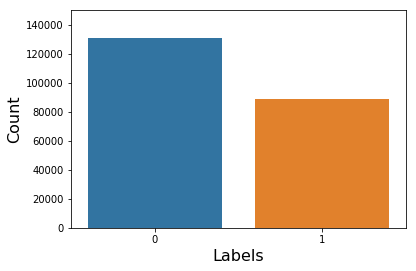

0    130908
1     89117
Name: label, dtype: int64

In [5]:
seaborn.countplot(train_labels.iloc[:,1])
pyplot.ylabel('Count', fontsize = 16)
pyplot.xlabel('Labels', fontsize = 16)
pyplot.ylim(0,150000)
pyplot.show()
train_labels.iloc[:,1].value_counts()

In [6]:
SAMPLE_SIZE = 80000
# take a random sample of class 0 with size equal to num samples in class 1
train_labels_0 = train_labels[train_labels['label'] == 0].sample(SAMPLE_SIZE, random_state = 0)
# filter out class 1
train_labels_1 = train_labels[train_labels['label'] == 1].sample(SAMPLE_SIZE, random_state = 0)

# concat the dataframes
train_labels = concat([train_labels_0, train_labels_1], axis = 0).reset_index(drop = True)
# shuffle
train_labels = shuffle(train_labels)

train_labels['label'].value_counts()

1    80000
0    80000
Name: label, dtype: int64

In [7]:
class_labels= train_labels['label']
train,valid = train_test_split(train_labels, test_size=0.2, random_state = 0, stratify =class_labels)
print("No. of train samples : ",train.shape)
print("No. of valid samples : ",valid.shape)

No. of train samples :  (128000, 2)
No. of valid samples :  (32000, 2)


In [8]:
train.head()

,id,label
57974,0bbc2cbd50475ecca6d7385ca8f0bfd17d1d7570,0
81935,c6a4806db034037cf47da6c5cb37495cf06163e9,1
87182,7762f8fdd1157cd69ec76c8e2ecb21771c5a6220,1
82530,c66b8dcaf03656369e15e8f23fec141c60d0755a,1
31672,a70dee70a7b1e71ead8f704ebd234f7e2cd9868a,0


In [9]:
valid.head()

,id,label
58452,cf769987bb42fe4763f72985940f96ecc3f09f16,0
102147,3abb47d148b99ebfe05e8c807578aee137885cc6,1
118438,633faec36e335b90633a2392cc467ba099157f1a,1
153713,645af4ab308daac080a44462f688c071da259021,1
59769,7f6f0305711371233b80e0634df188c6dee619dd,0


In [10]:
print("Copying train data")
for i in range(0,train.shape[0]):
    if(i%10000==0):
        print("Copied ",i,"Files")
    if train.iloc[i,1]==0:
        copyfile("../input/train/"+train.iloc[i,0]+".tif", "../train_folder/0/"+train.iloc[i,0]+".tif")
    else:
        copyfile("../input/train/"+train.iloc[i,0]+".tif", "../train_folder/1/"+train.iloc[i,0]+".tif")
print("Copying valid data")
for i in range(0,valid.shape[0]):
    if(i%5000==0):
        print("Copied ",i,"Files")
    if valid.iloc[i,1]==0:
        copyfile("../input/train/"+valid.iloc[i,0]+".tif", "../valid_folder/0/"+valid.iloc[i,0]+".tif")
    else:
        copyfile("../input/train/"+valid.iloc[i,0]+".tif", "../valid_folder/1/"+valid.iloc[i,0]+".tif")


Copying train data
Copied  0 Files
Copied  10000 Files
Copied  20000 Files
Copied  30000 Files
Copied  40000 Files
Copied  50000 Files
Copied  60000 Files
Copied  70000 Files
Copied  80000 Files
Copied  90000 Files
Copied  100000 Files
Copied  110000 Files
Copied  120000 Files
Copying valid data
Copied  0 Files
Copied  5000 Files
Copied  10000 Files
Copied  15000 Files
Copied  20000 Files
Copied  25000 Files
Copied  30000 Files


In [11]:
for i in os.listdir('../input/test'):
    copyfile("../input/test/"+i, "../test_folder/test/"+i)

In [12]:
print(len(os.listdir('../train_folder/0')))
print(len(os.listdir('../train_folder/1')))
print(len(os.listdir('../valid_folder/1')))
print(len(os.listdir('../valid_folder/1')))
print(len(os.listdir('../test_folder/test/')))

64000
64000
16000
16000
57458


In [13]:

IMAGE_SIZE = 96
train_path = '../train_folder/'
valid_path = '../valid_folder/'
test_path = '../test_folder/'

num_train_samples = len(train)
num_val_samples = len(valid)
train_batch_size = 32
val_batch_size = 32


train_steps = ceil(num_train_samples / train_batch_size)
val_steps = ceil(num_val_samples / val_batch_size)


datagen = ImageDataGenerator(rescale=1.0/255)

train_gen = datagen.flow_from_directory(train_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=train_batch_size,
                                        class_mode='categorical')

val_gen = datagen.flow_from_directory(valid_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=val_batch_size,
                                        class_mode='categorical')

test_gen = datagen.flow_from_directory(test_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=1,
                                        class_mode='categorical',
                                        shuffle=False)

Found 128000 images belonging to 2 classes.
Found 32000 images belonging to 2 classes.
Found 57458 images belonging to 1 classes.


In [14]:
model = Sequential()
model.add(Conv2D(32,kernel_size=(3,3),input_shape=(96,96,3),activation='relu',padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(Conv2D(32,kernel_size=(3,3),activation='relu',padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64,kernel_size=(3,3),activation='relu',padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(Conv2D(64,kernel_size=(3,3),activation='relu',padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128,kernel_size=(3,3),activation='relu',padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(Conv2D(128,kernel_size=(3,3),activation='relu',padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Dense(2, activation = "softmax"))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 96, 96, 32)        896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 96, 96, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 96, 96, 32)        9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 96, 96, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 48, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 48, 48, 64)        18496     
__________

In [15]:
model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])

In [16]:


checkpoint = ModelCheckpoint(filepath="checkpoint-{epoch:02d}.hdf5", verbose=1, 
                                       save_best_only=True, monitor="val_acc",mode = 'max')

reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor = 0.5, patience = 2, verbose = 1, mode = 'max', min_lr = 0.00001)                              
callbacks_list = [checkpoint, reduce_lr] # LR Scheduler Used here

history = model.fit_generator(train_gen, steps_per_epoch = train_steps, 
                    validation_data = val_gen,
                    validation_steps = val_steps,
                    epochs = 10,
                    verbose = 1,
                    callbacks = callbacks_list)

Epoch 1/10
4000/4000 [==============================] - 1206s 301ms/step - loss: 0.4063 - acc: 0.8221 - val_loss: 1.3806 - val_acc: 0.7428

Epoch 00001: val_acc improved from -inf to 0.74278, saving model to checkpoint-01.hdf5
Epoch 2/10
2413/4000 [=================>............] - ETA: 6:37 - loss: 0.3440 - acc: 0.8531

In [17]:
predictions = model.predict_generator(test_gen, steps=57458, verbose=1)

11289/57458 [====>.........................] - ETA: 1:06:28

In [18]:
df_preds = DataFrame(predictions, columns=['no_tumor', 'has_tumor'])
df_preds.head()

,no_tumor,has_tumor
0,0.000004,0.999996
1,0.034858,0.965142
2,0.002360,0.997640
3,0.519309,0.480691
4,0.993858,0.006142


In [19]:
# This outputs the file names in the sequence in which the generator processed the test images.
test_filenames = test_gen.filenames

# add the filenames to the dataframe
df_preds['file_names'] = test_filenames

# Create an id column
# A file name now has this format: 
# images/00006537328c33e284c973d7b39d340809f7271b.tif

# This function will extract the id:
# 00006537328c33e284c973d7b39d340809f7271b
def extract_id(x):
    
    # split into a list
    a = x.split('/')
    # split into a list
    b = a[1].split('.')
    extracted_id = b[0]
    
    return extracted_id

df_preds['id'] = df_preds['file_names'].apply(extract_id)

df_preds.head()

,no_tumor,has_tumor,file_names,id
0,0.000004,0.999996,test/00006537328c33e284c973d7b39d340809f7271b.tif,00006537328c33e284c973d7b39d340809f7271b
1,0.034858,0.965142,test/0000ec92553fda4ce39889f9226ace43cae3364e.tif,0000ec92553fda4ce39889f9226ace43cae3364e
2,0.002360,0.997640,test/00024a6dee61f12f7856b0fc6be20bc7a48ba3d2.tif,00024a6dee61f12f7856b0fc6be20bc7a48ba3d2
3,0.519309,0.480691,test/000253dfaa0be9d0d100283b22284ab2f6b643f6.tif,000253dfaa0be9d0d100283b22284ab2f6b643f6
4,0.993858,0.006142,test/000270442cc15af719583a8172c87cd2bd9c7746.tif,000270442cc15af719583a8172c87cd2bd9c7746


In [20]:
# Get the predicted labels.
# We were asked to predict a probability that the image has tumor tissue
y_pred = df_preds['has_tumor']

# get the id column
image_id = df_preds['id']

In [21]:
submission = DataFrame({'id':image_id, 
                           'label':y_pred, 
                          }).set_index('id')

submission.to_csv('submission.csv', columns=['label'])